# The state of cinema

## Overview

In today's content-driven world, audiences are seeking fresh, compelling stories. We're meeting this demand by launching a film studio that marries artistic vision with market intelligence. By analyzing real viewer behavior and box office patterns, we gain valuable insights about what stories connect with audiences. This informed approach allows us to create commercially viable films while minimizing the risks of being a new industry player. Ultimately, we're building a studio that makes smart, audience-focused entertainment decisions.

## Business Understanding

People can't get enough great stories. Whether on streaming services or at the movies. We see a real opportunity to create content that audiences will love. Since we're new to film production, we're being smart about it: we'll use data as our compass to understand what viewers actually want. By analyzing what types of movies perform best, what stories resonate with different audiences, and where the market has unmet needs, we'll make informed decisions about which projects to greenlight. This approach will help us compete with established studios while staying true to our vision of creating commercially successful entertainment.

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3 as sqlite 
import seaborn as sns
%matplotlib inline

## Data Understanding

To guide our production strategy, we will conduct comprehensive analysis using the IMDB database as our primary source. This robust dataset will enable us to examine:

- Genre performance trends across different markets
- Box office results (domestic/international)
- Audience rating patterns and demographic preferences
- Release timing and seasonal performance factors

Before analysis, we will:
- Validate data completeness for recent releases
- Assess potential biases in user-generated ratings

This rigorous approach will ensure our insights reflect genuine market patterns rather than data artifacts, allowing us to identify the genre characteristics and creative elements most associated with commercial success in today's market.

In [148]:
df_bom = pd.read_csv('Data/bom.movie_gross.csv')
df_bom.sample(3)

,title,studio,domestic_gross,foreign_gross,year
3110,Skyscraper,Uni.,68400000.0,236400000,2018
2067,Phoenix (2015),IFC,3200000.0,NaN,2015
2133,Peggy Guggenheim Art Addict,SD,498000.0,NaN,2015


In [149]:
conn = sqlite.connect('Data/im.db')

# Display tbale from the IMdb dataset
query_table = "SELECT * FROM sqlite_master where type='table';"
df_table = pd.read_sql_query(query_table, conn)
df_table

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [150]:
query_mb = "SELECT * FROM movie_basics;"
df_mb = pd.read_sql_query(query_mb, conn)
df_mb.sample(3)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
11060,tt1619021,Dead Hollywood Blondes,Dead Hollywood Blondes,2010,60.0,Musical
11739,tt1640569,The Super,The Super,2010,98.0,Horror
85256,tt4935926,Vicious Thunder,Vicious Thunder,2016,95.0,Action


In [151]:
query_rt = "SELECT * FROM movie_ratings;"
df_rt = pd.read_sql_query(query_rt, conn)
df_rt.sample(5)

,movie_id,averagerating,numvotes
11163,tt2639098,6.4,7
68045,tt3833568,6.3,7
33265,tt4048186,3.6,347
41956,tt7689934,7.5,71
72563,tt0938283,4.1,137734


## Data Preparation

In [152]:

df_mb['original_title'] = df_mb['original_title'].str.strip().str.title()
df_mb['primary_title'] = df_mb['primary_title'].str.strip().str.title()
df_bom['title'] = df_bom['title'].str.strip().str.title()

# Merge on original_title
df_original_title_merge = pd.merge(df_mb, df_bom, left_on='original_title', right_on='title', how='inner').drop( columns=['original_title', 'primary_title'])

# Merge on primary_title
df_primary_title_merge = pd.merge(df_mb, df_bom, left_on='primary_title', right_on='title', how='inner').drop( columns=['original_title', 'primary_title'])

# Merge together
df_movie_gross = pd.concat([df_original_title_merge, df_primary_title_merge]).drop_duplicates(subset=df_primary_title_merge.columns)

df_movie_gross_rt = pd.merge(df_movie_gross, df_rt, on='movie_id', how='inner')

df_movie_gross_rt['domestic_gross']  = pd.to_numeric(df_movie_gross_rt['domestic_gross'], errors='coerce') 
df_movie_gross_rt['foreign_gross'] = pd.to_numeric(df_movie_gross_rt['foreign_gross'], errors='coerce')  

# Handle missing values
df_movie_gross_rt['foreign_gross'] = df_movie_gross_rt['foreign_gross'].fillna(0)  # Replace NaN with 0
df_movie_gross_rt['domestic_gross'] = df_movie_gross_rt['domestic_gross'].fillna(0)  # Replace NaN with 0
df_movie_gross_rt['runtime_minutes'] = df_movie_gross_rt['runtime_minutes'].fillna(df_movie_gross_rt['runtime_minutes'].median())  # Replace fill with median to avoid skewing with 0
df_movie_gross_rt['worldwide_gross'] = (df_movie_gross_rt['domestic_gross'] + df_movie_gross_rt['foreign_gross']) 

df_movie_gross_rt['worldwide_gross_m'] = df_movie_gross_rt['worldwide_gross'] / 1_000_000
df_movie_gross_rt['domestic_gross_m'] = df_movie_gross_rt['domestic_gross'] / 1_000_000
df_movie_gross_rt['foreign_gross_m'] = df_movie_gross_rt['foreign_gross'] / 1_000_000


df_clean = df_movie_gross_rt
df_clean.sample(5)

,movie_id,start_year,runtime_minutes,genres,title,studio,domestic_gross,foreign_gross,year,averagerating,numvotes,worldwide_gross,worldwide_gross_m,domestic_gross_m,foreign_gross_m
3074,tt5606538,2017,125.0,Action,Confidential Assignment,CJ,476000.0,55500000.0,2017,6.5,1828,55976000.0,55.976,0.476,55.5
1571,tt2624412,2014,88.0,Drama,Boulevard,SM,126000.0,0.0,2015,5.8,7446,126000.0,0.126,0.126,0.0
298,tt1235189,2010,98.0,"Action,Comedy,Crime",Wild Target,Free,109000.0,3300000.0,2010,6.8,33915,3409000.0,3.409,0.109,3.3
1220,tt2097298,2015,129.0,"Biography,Drama,Sport","Mcfarland, Usa",BV,44500000.0,1200000.0,2015,7.4,31735,45700000.0,45.700,44.500,1.2
2170,tt4741754,2014,109.0,Thriller,The Call,TriS,51900000.0,16700000.0,2013,6.6,5,68600000.0,68.600,51.900,16.7


## Analysis and Results

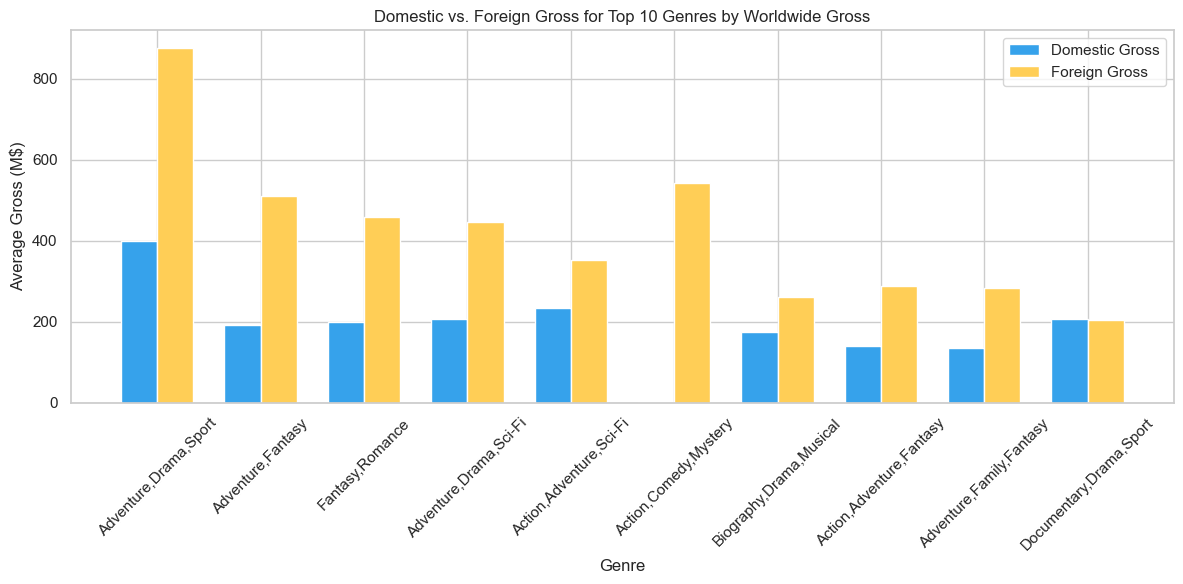

In [153]:
# Analysis 1: Top Grossing Genres at the Box Office 
genre_gross = df_clean.groupby('genres').agg({
    'worldwide_gross_m': ['mean', 'median', 'count'],
    'domestic_gross_m': 'mean',
    'foreign_gross_m': 'mean',
    'averagerating': 'mean'
}).round(2).sort_values(('worldwide_gross_m', 'mean'), ascending=False)

# Reset index and rename columns
genre_gross.columns = ['avg_gross_millions', 'median_gross_millions', 'movie_count', 'avg_domestic_gross_m', 'avg_foreign_gross_m', 'avg_rating']
genre_gross = genre_gross.reset_index()


# Double Vertical Bar Plot for Domestic and Foreign Gross
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(genre_gross.head(10)))

# Plot bars
plt.bar(index, genre_gross['avg_domestic_gross_m'].head(10), bar_width, label='Domestic Gross', color='#36A2EB')
plt.bar(index + bar_width, genre_gross['avg_foreign_gross_m'].head(10), bar_width, label='Foreign Gross', color='#FFCE56')

# Customize plot
plt.xlabel('Genre')
plt.ylabel('Average Gross (M$)')
plt.title('Domestic vs. Foreign Gross for Top 10 Genres by Worldwide Gross')
plt.xticks(index + bar_width / 2, genre_gross['genres'].head(10), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()




Correlation between numvotes and worldwide_gross: 0.65


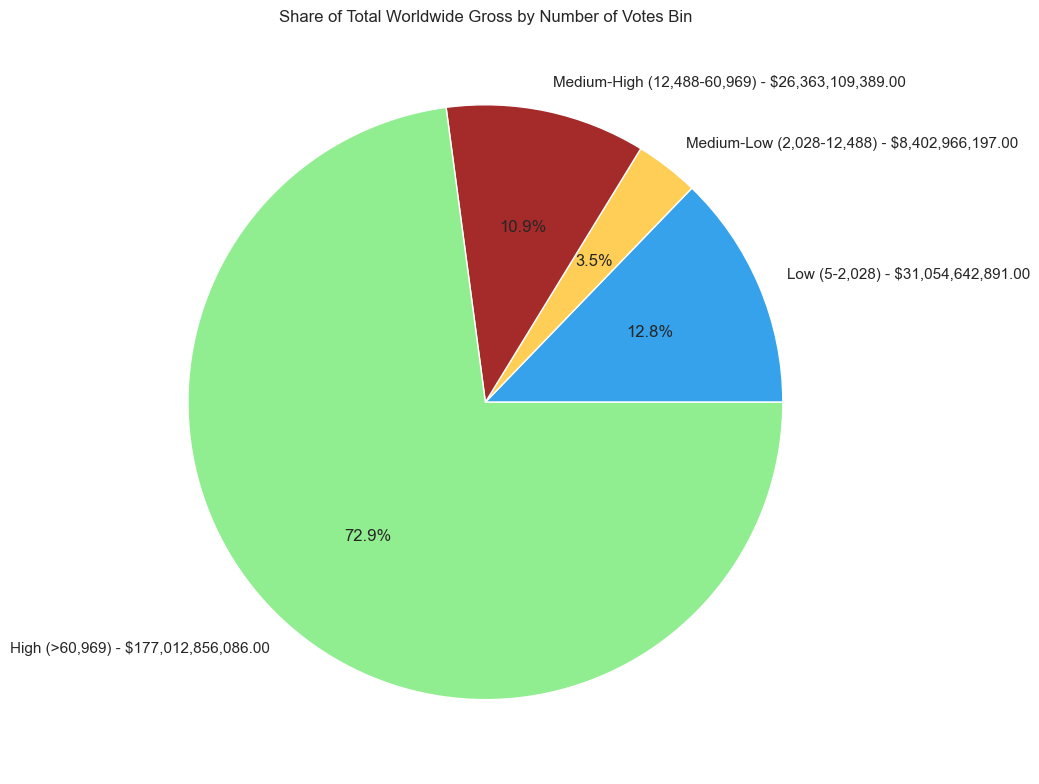

In [154]:
# Calculate Pearson correlation
correlation = df_clean[['numvotes', 'worldwide_gross']].corr().iloc[0, 1].round(2)
print(f"Correlation between numvotes and worldwide_gross: {correlation}")

# Bin numvotes into quartiles and get bin edges
bins = pd.qcut(df_clean['numvotes'], q=4, retbins=True, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
df_clean['votes_bin'] = bins[0]
bin_edges = bins[1].round().astype(int)

# Aggregate total gross by votes bin
votes_gross = df_clean.groupby('votes_bin', observed=True).agg({
    'worldwide_gross': ['sum', 'count'],
    'averagerating': 'mean'
}).round(2).reset_index()
votes_gross.columns = ['votes_bin', 'total_gross_millions', 'movie_count', 'avg_rating']

total_gross = votes_gross['total_gross_millions'].sum()
votes_gross['gross_share'] = (votes_gross['total_gross_millions'] / total_gross * 100).round(2)

bin_labels = [
    f"Low ({bin_edges[0]:,}-{bin_edges[1]:,}) - ${votes_gross['total_gross_millions'][0]:,.2f}",
    f"Medium-Low ({bin_edges[1]:,}-{bin_edges[2]:,}) - ${votes_gross['total_gross_millions'][1]:,.2f}",
    f"Medium-High ({bin_edges[2]:,}-{bin_edges[3]:,}) - ${votes_gross['total_gross_millions'][2]:,.2f}",
    f"High (>{bin_edges[3]:,}) - ${votes_gross['total_gross_millions'][3]:,.2f}"
]

plt.figure(figsize=(10, 8))
plt.pie(votes_gross['gross_share'], labels=bin_labels, autopct='%1.1f%%', 
        colors=['#36A2EB', '#FFCE56', 'brown', 'lightgreen'])
plt.title('Share of Total Worldwide Gross by Number of Votes Bin') 
plt.tight_layout()
plt.show()

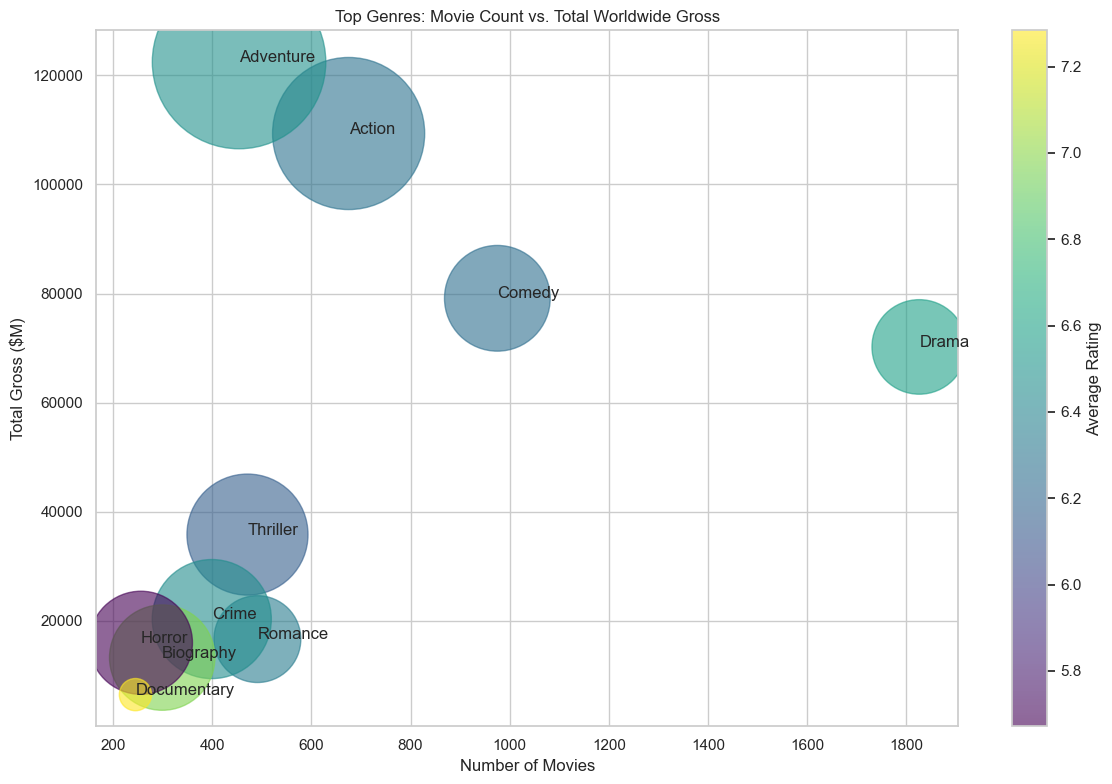

In [155]:
# Split genres and explode into separate rows
df_clean['genres_split'] = df_clean['genres'].str.split(',')
df_genres = df_clean.explode('genres_split')

# Group by genres_split to get movie count, total gross, and average numvotes
genre_stats = df_genres.groupby('genres_split').agg({
    'movie_id': 'count',
    'worldwide_gross': 'sum',
    'numvotes': 'mean',
    'averagerating': 'mean'
}).reset_index().rename(columns={'movie_id': 'movie_count', 'worldwide_gross': 'total_gross_millions', 'numvotes': 'avg_numvotes'})

# Convert gross to millions
genre_stats['total_gross_millions'] = (genre_stats['total_gross_millions'] / 1_000_000).round(2)
genre_stats['avg_numvotes'] = genre_stats['avg_numvotes'].round(0).astype(int)

# Select top 10 genres by movie count
top_genres = genre_stats.nlargest(10, 'movie_count')


plt.figure(figsize=(12, 8))
scatter = plt.scatter(
    top_genres['movie_count'], 
    top_genres['total_gross_millions'], 
    s=top_genres['avg_numvotes'] / 10,
    c=top_genres['averagerating'], 
    cmap='viridis', 
    alpha=0.6
)
plt.colorbar(label='Average Rating')
for i, genre in enumerate(top_genres['genres_split']):
    plt.annotate(genre, (top_genres['movie_count'].iloc[i], top_genres['total_gross_millions'].iloc[i]))
plt.title('Top Genres: Movie Count vs. Total Worldwide Gross')
plt.xlabel('Number of Movies')
plt.ylabel('Total Gross ($M)')
plt.grid(True)
plt.tight_layout()
plt.show()
 

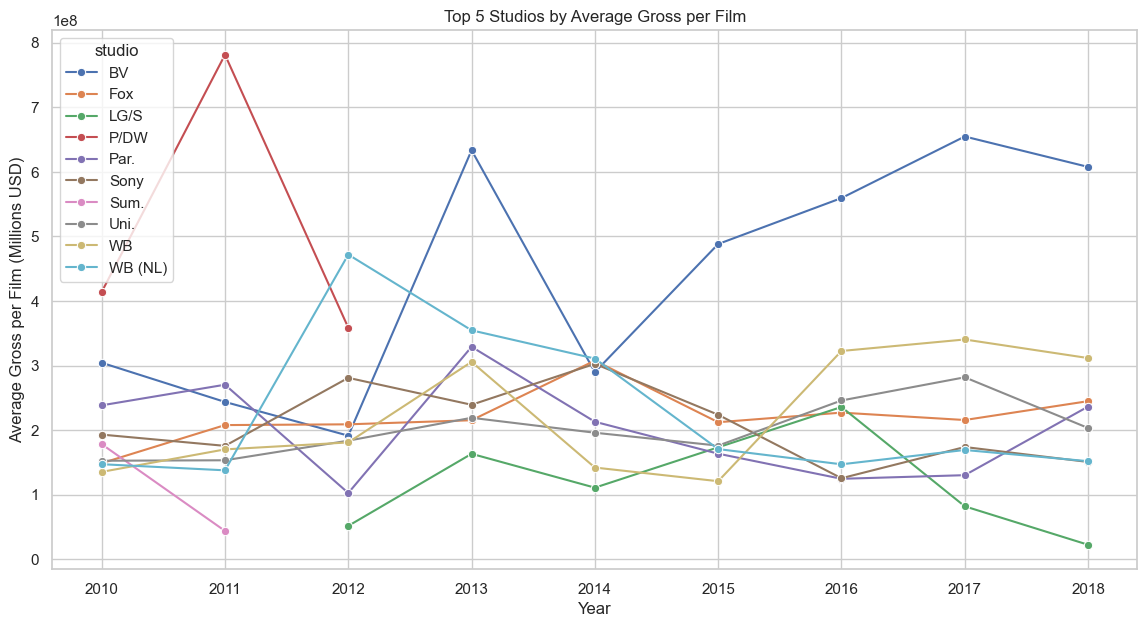

In [156]:
# Calculate gross per film
studio_performance['gross_per_film'] = studio_performance['total_gross'] / studio_performance['movie_count']

# Plot most efficient studios
plt.figure(figsize=(14, 7))
efficient_studios = studio_performance.groupby('studio')['gross_per_film'].mean().nlargest(10).index
sns.lineplot(data=studio_performance[studio_performance['studio'].isin(efficient_studios)],
             x='year',
             y='gross_per_film',
             hue='studio',
             marker='o')
plt.title('Top 5 Studios by Average Gross per Film')
plt.ylabel('Average Gross per Film (Millions USD)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

### Business Recommendation 1

Focus on High-Grossing Genres:
The analysis reveals that certain genres, such as Action, Adventure, and Comedy, consistently perform well at the box office. To maximize ROI, the studio should prioritize producing films in these genres. Additionally, hybrid genres (e.g., Action-Drama or Adventure-Comedy) have shown strong audience appeal, offering opportunities for creative storytelling while minimizing risk.

### Business Recommendation 2

Leverage International Markets:
Foreign box office revenue often surpasses domestic earnings, indicating the importance of global appeal. The studio should:
Develop culturally adaptable content with universal themes.
Partner with international distributors to enhance market penetration.
Invest in marketing campaigns tailored to key regions like Asia and Europe.

### Business Recommendation 3

Enhance competitiveness by leveraging insights from high-performing studios and forming strategic collaborations:
Analysis identifies studios like BV, Fox, and LG/S as consistent high performers in the market. Partner with top-performing studios like (co-productions, distribution deals) to leverage the company expertise and market reach.

## Conclusion

By strategically partnering with top-performing studios, prioritizing high-grossing genres, expanding into international markets, and optimizing budget allocation, the new film studio can:
- Accelerate market entry by leveraging proven industry strategies
- Minimize financial and creative risks through data-driven decisions
- Establish competitive positioning in the global film industry
- Produce commercially successful films that align with audience preferences.

### Next Steps

Finalize partnership opportunities with leading studios
Develop a balanced production slate combining franchise films and original content
Implement robust market research for international expansion
Establish budget monitoring systems for optimal resource allocation
This comprehensive strategy ensures both immediate competitiveness and long-term sustainability in the evolving film landscape.